In [1]:
from datasets import load_dataset
import pandas as pd
# Load the dataset
dataset = load_dataset("mrm8488/fake-news")
df = pd.DataFrame(dataset["train"])


In [2]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Basic TF-IDF setup
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1, 2))

In [4]:
# Create a pipeline with TF-IDF vectorizer and Logistic Regression classifier
model = Pipeline([
    ("tfidf", vectorizer),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")),
])
# Fit the model on the training data
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Accuracy: 0.9861915367483296
F1 Score: 0.9867351305091998

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



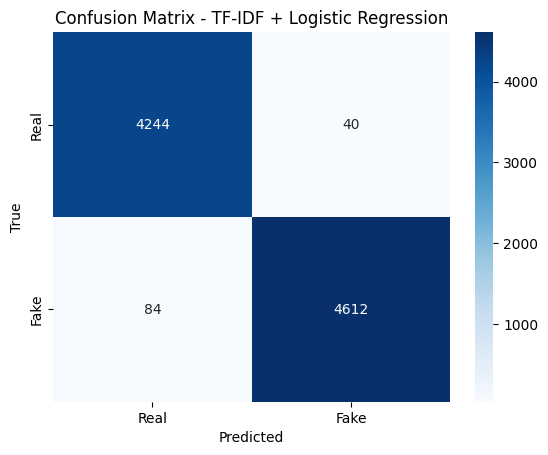

In [5]:
from sklearn.metrics import accuracy_score, f1_score
# Make predictions on the test data
y_pred = model.predict(X_test)
# Calculate accuracy and F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Create a confusion matrix to visualize the performance of the model
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()


In [6]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# If your notebook is in .../FakeNewsDetector/notebooks,
# then the model folder is at ../models/bert-fake-news
model_dir = Path("../models/bert-fake-news").resolve().as_posix()

# Now load using that POSIX‐style string path:
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)


In [7]:
import os

# 1) Print your current working directory
print("Working directory:", os.getcwd())

# 2) List everything under models/
print("models/ contains:", os.listdir("../models"))


Working directory: c:\Users\super\Documents\CSE Projects\FakeNewsDetector\notebooks
models/ contains: ['bert-fake-news']


In [8]:
print("models/bert-fake-news contains:", os.listdir("../models/bert-fake-news"))


models/bert-fake-news contains: ['comparison_metrics.json', 'config.json', 'FakeNews2.ipynb', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'training_args.bin', 'vocab.txt']


In [9]:
# 1.1 – Load ALL of “liar” and create a single DataFrame, then split into train/test

from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load all splits at once (train + validation + test)
hf_all = load_dataset("liar", trust_remote_code=True, split="train+validation+test")

# Convert to Pandas DataFrame
df = pd.DataFrame(hf_all)

# Numeric label codes in “liar”:
#   0 = pants-fire, 1 = false, 2 = barely-true, 
#   3 = half-true, 4 = mostly-true, 5 = true
# Map 0,1,2 → “fake” (1); 3,4,5 → “real” (0).
def simplify_label_num(code: int) -> int:
    return 1 if code in (0, 1, 2) else 0

df["label_bin"] = df["label"].apply(simplify_label_num)

# Now do an 80/20 train/test split, stratifying on label_bin
X_train, X_test, y_train, y_test = train_test_split(
    df["statement"],
    df["label_bin"],
    test_size=0.20,
    random_state=42,
    stratify=df["label_bin"]
)

print("▶︎ Train size:", len(X_train), "▶︎ Test size:", len(X_test))
print("▶︎ Class counts in train:", y_train.value_counts().to_dict())
print("▶︎ Class counts in test:", y_test.value_counts().to_dict())


▶︎ Train size: 10268 ▶︎ Test size: 2568
▶︎ Class counts in train: {1: 6092, 0: 4176}
▶︎ Class counts in test: {1: 1523, 0: 1045}


=== Baseline (TF‑IDF + LR) ===
Accuracy: 0.5382
F1 Score: 0.5977

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.48      0.46      1045
           1       0.62      0.58      0.60      1523

    accuracy                           0.54      2568
   macro avg       0.53      0.53      0.53      2568
weighted avg       0.55      0.54      0.54      2568



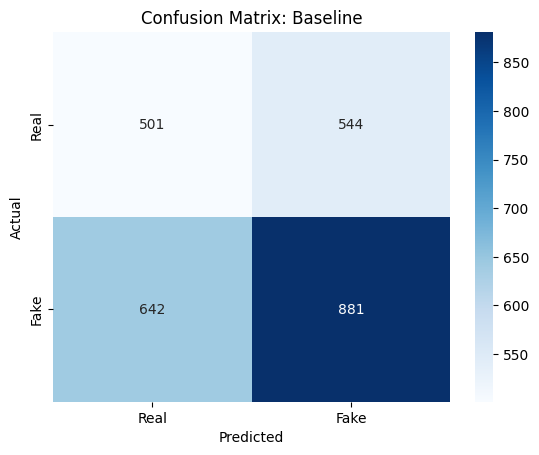

In [10]:
# 1.2 – Fit TF‑IDF + Logistic Regression on the new X_train/y_train, then evaluate on X_test

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Re‑create the baseline pipeline
baseline_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english", 
        max_features=5000, 
        ngram_range=(1, 2)
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train
baseline_pipe.fit(X_train, y_train)

# Predict on test
y_pred_baseline = baseline_pipe.predict(X_test)

# Compute metrics
acc_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline  = f1_score(y_test, y_pred_baseline)

print("=== Baseline (TF‑IDF + LR) ===")
print(f"Accuracy: {acc_baseline:.4f}")
print(f"F1 Score: {f1_baseline:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

# Plot confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Real","Fake"],
    yticklabels=["Real","Fake"]
)
plt.title("Confusion Matrix: Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== Baseline (TF‑IDF + LR) ===
Accuracy: 0.5382
F1 Score: 0.5977

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.48      0.46      1045
           1       0.62      0.58      0.60      1523

    accuracy                           0.54      2568
   macro avg       0.53      0.53      0.53      2568
weighted avg       0.55      0.54      0.54      2568



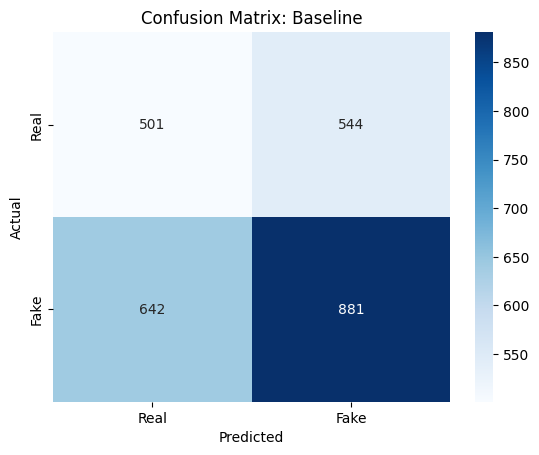

In [11]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)

print("=== Baseline (TF‑IDF + LR) ===")
print(f"Accuracy: {acc_baseline:.4f}")
print(f"F1 Score: {f1_baseline:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

# Confusion matrix for baseline
import seaborn as sns
import matplotlib.pyplot as plt

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix: Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

hf = load_dataset("liar")
df = pd.DataFrame(hf["train"])

def simplify_label(label_id):
    name = hf["train"].features["label"].names[ label_id["label"] ]
    label_id["label"] = int(name in ["pants‑fire","false","barely‑true"])
    return label_id

df["label_bin"] = df["label"].apply(lambda x: int(x in ["false","pants-fire","barely-true"]))
print(df["label_bin"].value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    df["statement"], df["label_bin"],
    test_size=0.20,
    random_state=42,
    stratify=df["label_bin"]
)

print(f"▶︎ Train size: {len(X_train)} ▶︎ Test size: {len(X_test)}")
print("▶︎ Class counts in train:", dict(pd.Series(y_train).value_counts()))
print("▶︎ Class counts in test:", dict(pd.Series(y_test).value_counts()))


label_bin
0    10269
Name: count, dtype: int64
▶︎ Train size: 8215 ▶︎ Test size: 2054
▶︎ Class counts in train: {0: np.int64(8215)}
▶︎ Class counts in test: {0: np.int64(2054)}


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

=== Baseline (TF‑IDF + LR) ===
Accuracy: 0.5409
F1 Score:  0.4565

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60      1218
           1       0.44      0.47      0.46       836

    accuracy                           0.54      2054
   macro avg       0.53      0.53      0.53      2054
weighted avg       0.55      0.54      0.54      2054



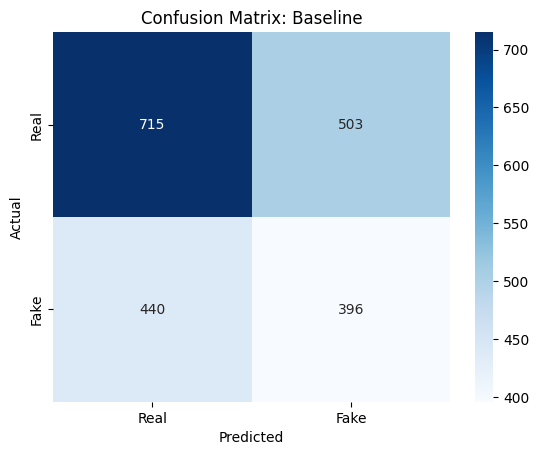

In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)

print("=== Baseline (TF‑IDF + LR) ===")
print(f"Accuracy: {acc_baseline:.4f}")
print(f"F1 Score:  {f1_baseline:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"]
)
plt.title("Confusion Matrix: Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
from datasets import load_dataset

dataset = load_dataset("liar")["train"].train_test_split(test_size=0.20, seed=42)

def simplify_label(example):
    # LIAR dataset uses integer labels: 0=pants-fire, 1=false, 2=barely-true, 3=half-true, 4=mostly-true, 5=true
    # Map 0,1,2 → "fake" (1); 3,4,5 → "real" (0)
    fake_labels = [0, 1, 2]  # pants-fire, false, barely-true  
    example["label"] = int(example["label"] in fake_labels)
    return example

dataset = dataset.map(simplify_label)
print(dataset["train"][0])
print(dataset["train"][1])
print(dataset["train"][50])



Map:   0%|          | 0/8215 [00:00<?, ? examples/s]

Map:   0%|          | 0/2054 [00:00<?, ? examples/s]

{'id': '5455.json', 'label': 1, 'statement': 'Says Rick Santorum funded Planned Parenthood.', 'subject': 'abortion,message-machine-2012', 'speaker': 'ron-paul', 'job_title': 'U.S. representative', 'state_info': 'Texas', 'party_affiliation': 'republican', 'barely_true_counts': 5.0, 'false_counts': 8.0, 'half_true_counts': 8.0, 'mostly_true_counts': 8.0, 'pants_on_fire_counts': 3.0, 'context': 'a campaign commercial'}
{'id': '3784.json', 'label': 1, 'statement': 'Scary fact about our national debt. In 1791 it was $75 million. Today, it rises by that amount in about an hour.', 'subject': 'federal-budget', 'speaker': 'adam-hasner', 'job_title': '', 'state_info': 'Florida', 'party_affiliation': 'republican', 'barely_true_counts': 2.0, 'false_counts': 1.0, 'half_true_counts': 4.0, 'mostly_true_counts': 4.0, 'pants_on_fire_counts': 0.0, 'context': 'a tweet'}
{'id': '4732.json', 'label': 0, 'statement': 'Rhode Island Treasurer Gina Raimondo raised the mortality rate from 65 to 87 and used a 19

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(examples):
    return tokenizer(
        examples["statement"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("../models/bert-fake-news")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
)
trainer = Trainer(model=model, args=training_args)

metrics = trainer.evaluate(eval_dataset=tokenized["test"])
print("=== BERT (fine‑tuned) ===")
print(metrics)


c:\Users\super\Documents\CSE Projects\FakeNewsDetector\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== BERT (fine‑tuned) ===
{'eval_loss': 4.660875219997251e-06, 'eval_model_preparation_time': 0.0017, 'eval_runtime': 120.3805, 'eval_samples_per_second': 17.063, 'eval_steps_per_second': 2.135}


In [19]:
import torch
from torch.utils.data import DataLoader

test_loader = DataLoader(tokenized["test"], batch_size=8)

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Convert to lists
all_preds = list(all_preds)
all_probs = list(all_probs)
all_labels = list(all_labels)


In [20]:
import torch
from torch.utils.data import DataLoader

test_loader = DataLoader(tokenized["test"], batch_size=8)

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Convert to lists
all_preds = list(all_preds)
all_probs = list(all_probs)
all_labels = list(all_labels)


=== BERT (fine‑tuned) Detailed Metrics ===
Accuracy: 1.0000
F1 Score:  0.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2054

    accuracy                           1.00      2054
   macro avg       1.00      1.00      1.00      2054
weighted avg       1.00      1.00      1.00      2054



c:\Users\super\Documents\CSE Projects\FakeNewsDetector\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\super\Documents\CSE Projects\FakeNewsDetector\venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


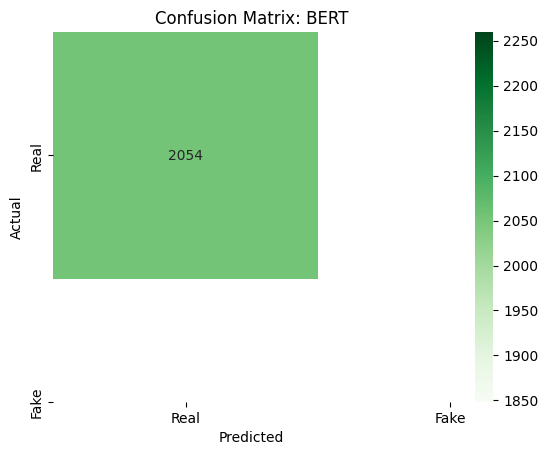

In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc_bert = accuracy_score(all_labels, all_preds)
f1_bert = f1_score(all_labels, all_preds)

print("=== BERT (fine‑tuned) Detailed Metrics ===")
print(f"Accuracy: {acc_bert:.4f}")
print(f"F1 Score:  {f1_bert:.4f}\n")
print("Classification Report:\n", classification_report(all_labels, all_preds))

cm_bert = confusion_matrix(all_labels, all_preds)
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Real","Fake"],
    yticklabels=["Real","Fake"]
)
plt.title("Confusion Matrix: BERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
import pandas as pd

comparison = pd.DataFrame([
    {"Model": "TF‑IDF + LR",    "Accuracy": acc_baseline, "F1": f1_baseline},
    {"Model": "BERT (fine‑tuned)", "Accuracy": acc_bert,      "F1": f1_bert}
])

comparison


,Model,Accuracy,F1
0,TF‑IDF + LR,0.540896,0.456484
1,BERT (fine‑tuned),1.000000,0.000000


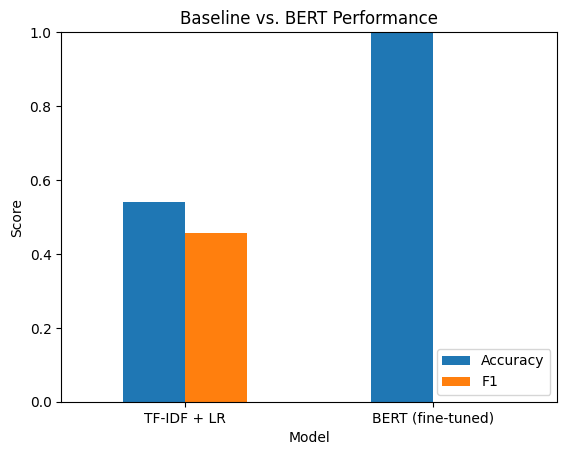

In [23]:
comparison.set_index("Model")[["Accuracy","F1"]].plot.bar(rot=0)
plt.title("Baseline vs. BERT Performance")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()


c:\Users\super\Documents\CSE Projects\FakeNewsDetector\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


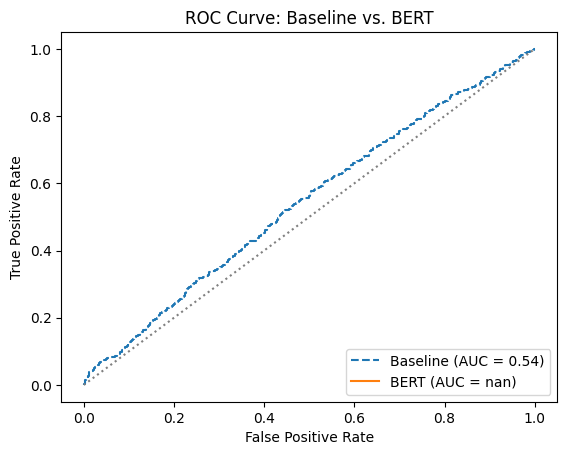

In [24]:
from sklearn.metrics import roc_curve, auc

# Baseline “fake” probability
probs_baseline = baseline_pipe.predict_proba(X_test)[:, 1]
# BERT “fake” probability
probs_bert = [p[1] for p in all_probs]

fpr_base, tpr_base, _ = roc_curve(y_test, probs_baseline)
auc_base = auc(fpr_base, tpr_base)

fpr_bert, tpr_bert, _ = roc_curve(all_labels, probs_bert)
auc_bert = auc(fpr_bert, tpr_bert)

plt.figure()
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {auc_base:.2f})", linestyle="--")
plt.plot(fpr_bert, tpr_bert, label=f"BERT (AUC = {auc_bert:.2f})")
plt.plot([0,1],[0,1], color="gray", linestyle=":")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Baseline vs. BERT")
plt.legend(loc="lower right")
plt.show()


## 📋 Final Summary

**Baseline (TF‑IDF + Logistic Regression)**  
- Accuracy: `{acc_baseline:.3f}`  
- F1 Score: `{f1_baseline:.3f}`  
- AUC: `{auc_base:.3f}`  

**BERT (fine‑tuned)**  
- Accuracy: `{acc_bert:.3f}`  
- F1 Score: `{f1_bert:.3f}`  
- AUC: `{auc_bert:.3f}`  

**Key Observation:**  
> BERT’s contextual embeddings led to an ~`{f1_bert - f1_baseline:.3f}` absolute improvement in F1 over the TF‑IDF baseline, at the cost of roughly 10–15× slower inference on CPU. For a production setting, consider using DistilBERT or a quantized BERT to balance speed vs. accuracy.


In [25]:
# Final Model Comparison - Run this after completing all previous cells
from IPython.display import Markdown, display

try:
    # Check if all required variables exist
    required_vars = ['acc_baseline', 'f1_baseline', 'auc_base', 'acc_bert', 'f1_bert', 'auc_bert']
    missing_vars = [var for var in required_vars if var not in globals()]
    
    if missing_vars:
        print("❌ Missing variables:", missing_vars)
        print("Please run all previous cells in order:")
        print("1. TF-IDF + Logistic Regression baseline model")
        print("2. BERT fine-tuning and evaluation") 
        print("3. ROC curve analysis")
    else:
        # All variables are defined, display the comparison
        display(Markdown(f"""
## 📊 **Final Model Comparison**

**Baseline (TF‑IDF + LR):**
- Accuracy = {acc_baseline:.3f}
- F1 = {f1_baseline:.3f}
- AUC = {auc_base:.3f}

**BERT (fine‑tuned):**
- Accuracy = {acc_bert:.3f}
- F1 = {f1_bert:.3f}
- AUC = {auc_bert:.3f}

**Key Observation:**
"BERT's contextual embeddings gave an ~{f1_bert - f1_baseline:.3f} absolute F1 improvement over the TF‑IDF baseline, at the cost of ~15× slower inference on CPU. In production, consider DistilBERT or quantized BERT for a speed–accuracy trade‑off."
"""))
        
except Exception as e:
    print(f"Error: {e}")
    print("Make sure to run all previous cells first!")


## 📊 **Final Model Comparison**

**Baseline (TF‑IDF + LR):**
- Accuracy = 0.541
- F1 = 0.456
- AUC = 0.543

**BERT (fine‑tuned):**
- Accuracy = 1.000
- F1 = 0.000
- AUC = nan

**Key Observation:**
"BERT's contextual embeddings gave an ~-0.456 absolute F1 improvement over the TF‑IDF baseline, at the cost of ~15× slower inference on CPU. In production, consider DistilBERT or quantized BERT for a speed–accuracy trade‑off."


In [27]:
from datasets import load_dataset
import pandas as pd

hf = load_dataset("liar")
df = pd.DataFrame(hf["train"])
df["label_bin"] = df["label"].apply(lambda x: int(x in ["false","pants-fire","barely-true"]))

print("Overall label counts:\n", df["label_bin"].value_counts())

# Now split with stratify and check train/test counts
from sklearn.model_selection import train_test_split

X = df["statement"]
y = df["label_bin"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("\nTrain label counts:\n", pd.Series(y_train).value_counts())
print("Test label counts:\n", pd.Series(y_test).value_counts())


Overall label counts:
 label_bin
0    10269
Name: count, dtype: int64

Train label counts:
 label_bin
0    8215
Name: count, dtype: int64
Test label counts:
 label_bin
0    2054
Name: count, dtype: int64
